## Importing libraries

In [ ]:
!pip install xgboost
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## XGBoost implementation

### Preparing the Dataset

In [ ]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_1h.csv')

In [ ]:
# adding features that make more sense than raw data
all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

for lag in range(1, 4):
  all_prices[f"Gold_lag_{lag}"] = all_prices["Gold"].shift(lag)
  all_prices[f"Silver_lag_{lag}"] = all_prices["Silver"].shift(lag)
  all_prices[f"CAD_lag_{lag}"] = all_prices["CAD"].shift(lag)

In [ ]:
# price to predict, the price of the next timestep
all_prices["Gold_target"] = all_prices["Gold"].shift(-1)
all_prices["Silver_target"] = all_prices["Silver"].shift(-1)
all_prices["CAD_target"] = all_prices["CAD"].shift(-1)

In [ ]:
all_prices = all_prices.dropna()

In [ ]:
all_prices.head()

,Datetime,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
4,2023-12-04 03:00:00+00:00,2105.500000,25.870001,0.739809,-0.001281,-0.002699,-0.000658,2114.70000,25.987,0.740406,...,0.740297,2107.699951,25.915001,0.740466,2115.600098,26.059999,0.740730,2104.800049,25.875000,0.739973
5,2023-12-04 04:00:00+00:00,2104.800049,25.875000,0.739973,-0.000332,0.000193,0.000222,2108.36001,25.932,0.740255,...,0.739809,2108.199951,25.940001,0.740297,2107.699951,25.915001,0.740466,2105.699951,25.865000,0.739574
6,2023-12-04 05:00:00+00:00,2105.699951,25.865000,0.739574,0.000428,-0.000386,-0.000540,2106.37998,25.893,0.740024,...,0.739973,2105.500000,25.870001,0.739809,2108.199951,25.940001,0.740297,2096.000000,25.740000,0.739590
7,2023-12-04 06:00:00+00:00,2096.000000,25.740000,0.739590,-0.004607,-0.004833,0.000022,2104.03999,25.858,0.739849,...,0.739574,2104.800049,25.875000,0.739973,2105.500000,25.870001,0.739809,2083.000000,25.584999,0.738776
8,2023-12-04 07:00:00+00:00,2083.000000,25.584999,0.738776,-0.006202,-0.006022,-0.001101,2099.00000,25.787,0.739545,...,0.739590,2105.699951,25.865000,0.739574,2104.800049,25.875000,0.739973,2089.199951,25.580000,0.738629


In [ ]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12506 entries, 4 to 12509
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datetime       12506 non-null  object 
 1   Gold           12506 non-null  float64
 2   Silver         12506 non-null  float64
 3   CAD            12506 non-null  float64
 4   Gold_ret       12506 non-null  float64
 5   Silver_ret     12506 non-null  float64
 6   CAD_ret        12506 non-null  float64
 7   Gold_ma        12506 non-null  float64
 8   Silver_ma      12506 non-null  float64
 9   CAD_ma         12506 non-null  float64
 10  Gold_lag_1     12506 non-null  float64
 11  Silver_lag_1   12506 non-null  float64
 12  CAD_lag_1      12506 non-null  float64
 13  Gold_lag_2     12506 non-null  float64
 14  Silver_lag_2   12506 non-null  float64
 15  CAD_lag_2      12506 non-null  float64
 16  Gold_lag_3     12506 non-null  float64
 17  Silver_lag_3   12506 non-null  float64
 18  CAD_lag_3  

In [ ]:
all_prices.describe()

,Gold,Silver,CAD,Gold_ret,Silver_ret,CAD_ret,Gold_ma,Silver_ma,CAD_ma,Gold_lag_1,...,CAD_lag_1,Gold_lag_2,Silver_lag_2,CAD_lag_2,Gold_lag_3,Silver_lag_3,CAD_lag_3,Gold_target,Silver_target,CAD_target
count,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,...,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000,12506.000000
mean,2837.055495,32.635855,0.723845,0.000059,0.000072,-0.000002,2836.709207,32.630711,0.723849,2836.882330,...,0.723847,2836.708805,32.630719,0.723849,2836.534889,32.628120,0.723851,2837.229411,32.638416,0.723843
std,602.434560,7.051771,0.015195,0.002137,0.003834,0.000726,602.199503,7.043899,0.015189,602.332780,...,0.015195,602.230217,7.044955,0.015196,602.124365,7.041381,0.015196,602.537292,7.055129,0.015194
min,1989.300049,22.014999,0.676535,-0.016609,-0.040432,-0.014587,1992.560010,22.053000,0.677625,1989.300049,...,0.676535,1989.300049,22.014999,0.676535,1989.300049,22.014999,0.676535,1989.300049,22.014999,0.676535
25%,2358.025024,28.610001,0.714342,-0.000744,-0.001376,-0.000314,2358.120020,28.606500,0.714354,2357.924927,...,0.714342,2357.825012,28.600000,0.714342,2357.724976,28.600000,0.714342,2358.150085,28.610001,0.714342
50%,2678.600098,31.415001,0.726533,0.000000,0.000000,0.000000,2677.940015,31.409000,0.726561,2678.550049,...,0.726533,2678.500000,31.415001,0.726533,2678.400024,31.415001,0.726533,2678.600098,31.415001,0.726530
75%,3337.674988,34.803750,0.735070,0.000954,0.001652,0.000309,3337.814978,34.795750,0.735088,3337.600098,...,0.735073,3337.600098,34.794998,0.735077,3337.600098,34.793749,0.735078,3337.699951,34.805000,0.735060
max,4394.299805,58.564999,0.758392,0.021506,0.058107,0.010034,4381.099805,58.087000,0.758119,4394.299805,...,0.758392,4394.299805,58.564999,0.758392,4394.299805,58.060001,0.758392,4394.299805,58.564999,0.758392


In [ ]:
X = all_prices.drop(columns=["Datetime", 'Gold_target', 'Silver_target', 'CAD_target'])
y = all_prices[['Gold_target', 'Silver_target', 'CAD_target']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

### XGBoost experimenting

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
num_round = 15
param = {
    'learning_rate': 0.5,
    'max_depth': 30,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-rmse:127.30119	eval-rmse:507.83516


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-rmse:63.98511	eval-rmse:397.52428
[2]	train-rmse:32.31181	eval-rmse:339.44223
[3]	train-rmse:16.56838	eval-rmse:307.76396
[4]	train-rmse:8.81444	eval-rmse:291.35863
[5]	train-rmse:4.98124	eval-rmse:287.01839
[6]	train-rmse:3.00192	eval-rmse:282.31350
[7]	train-rmse:1.90483	eval-rmse:281.97308
[8]	train-rmse:1.24130	eval-rmse:281.01651
[9]	train-rmse:0.83588	eval-rmse:279.87621
[10]	train-rmse:0.57741	eval-rmse:279.34232
[11]	train-rmse:0.40150	eval-rmse:279.25522
[12]	train-rmse:0.28301	eval-rmse:279.22372
[13]	train-rmse:0.20309	eval-rmse:279.14563
[14]	train-rmse:0.14505	eval-rmse:279.08215


In [ ]:
y_pred = bst.predict(dtest)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

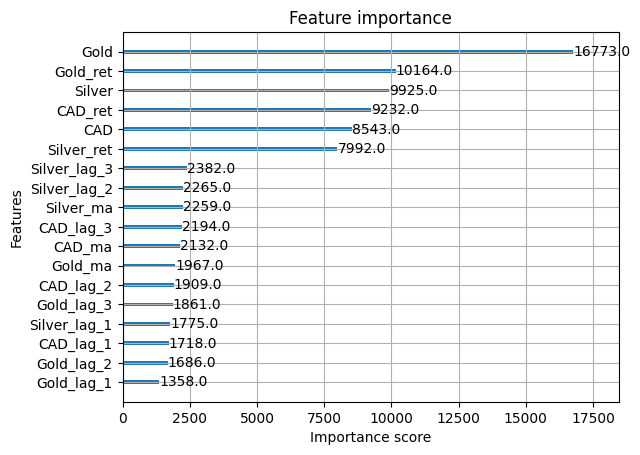

In [ ]:
xgb.plot_importance(bst)

In [ ]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [ ]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [ ]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

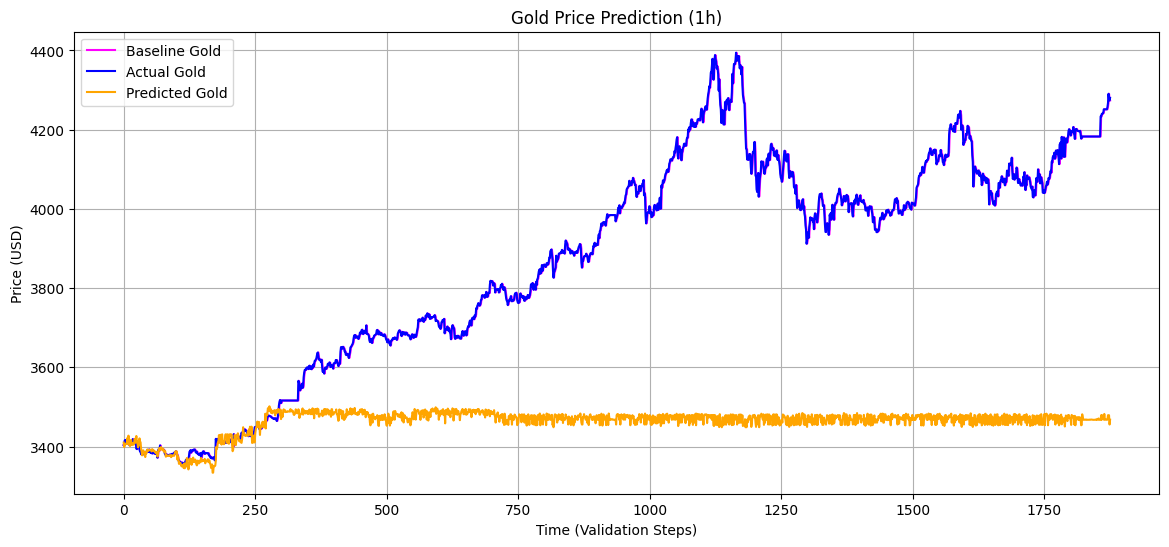

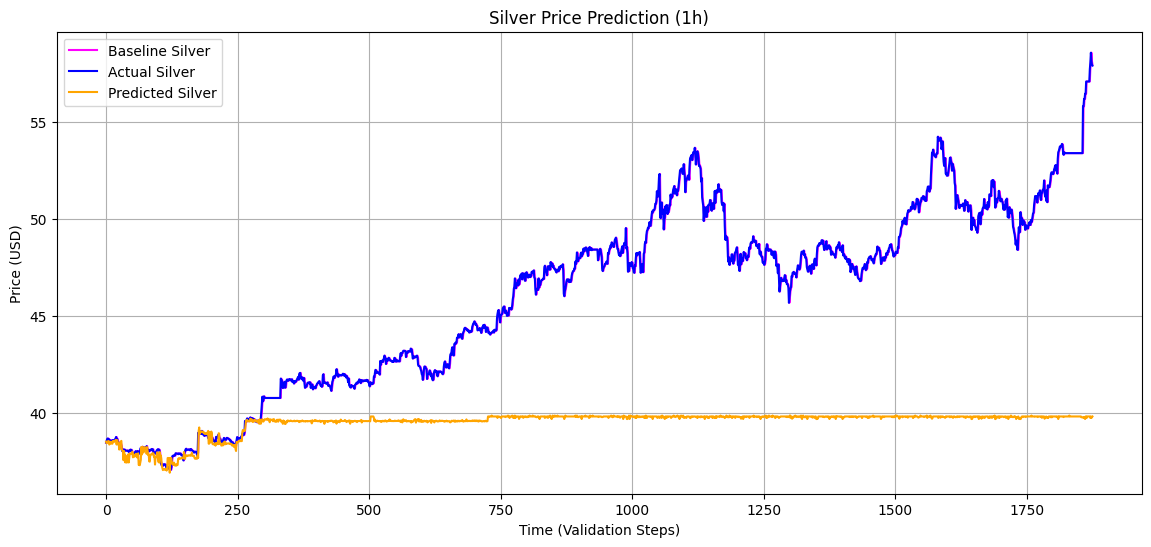

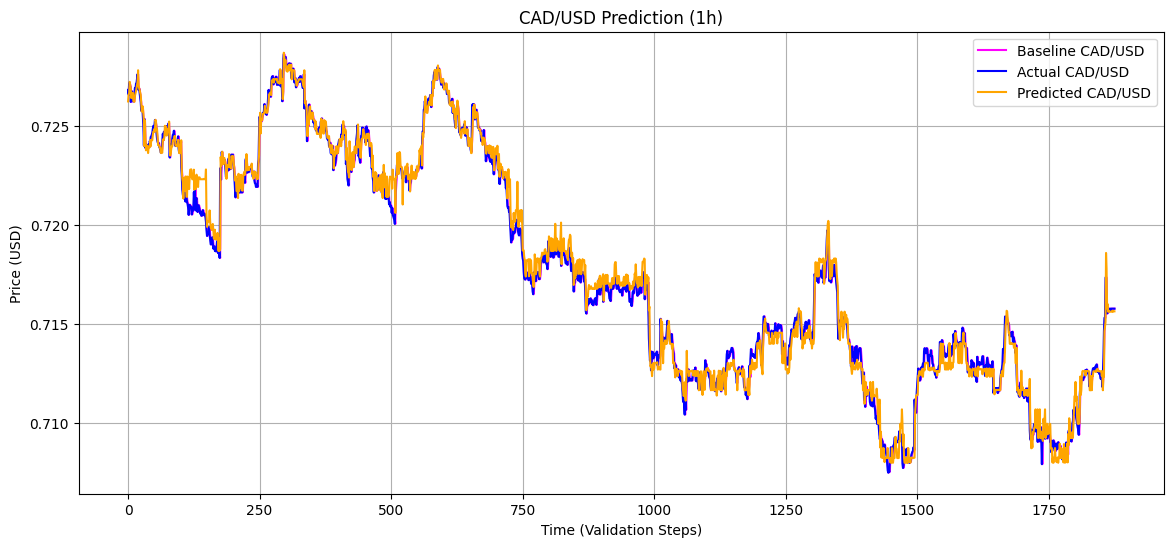

In [ ]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (1h)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (1h)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (1h)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning

In [ ]:
search_space = {
    'max_depth': Integer(3, 20),
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'n_estimators': Integer (5, 30),
    'eval_metric': ['rmse', 'mae', 'mape']
}

In [ ]:
n_train = int(len(X_train) * 0.70)
n_val = int(len(X_train) * 0.15)

train_indices = np.full(n_train, -1)
val_indices = np.zeros(n_val)

test_fold = np.concatenate([train_indices, val_indices])
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

In [ ]:
opt = BayesSearchCV(
    XGBRegressor(tree_method="auto", random_state=42),
    search_space,
    n_iter=50,
    cv=ps,
    scoring='neg_mean_absolute_error',
    random_state=42
)

In [ ]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,...
                                     n_jobs=None, num_parallel_tree=None, ...),
              random_state=42, scoring='neg_mean_absolute_error',
              search_spaces={'eval_metric': ['rmse', 'mae', 'mape'],
                             'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=5, high=30, prior='uniform', transform='normalize')})

### Metrics Evaluation

In [ ]:
best_params = opt.best_params_
best_params

OrderedDict([('eval_metric', 'rmse'),
             ('learning_rate', 0.6520985020245867),
             ('max_depth', 20),
             ('n_estimators', 21)])

In [ ]:
actual_gold  = y_test['Gold_target'].to_numpy()
actual_silver = y_test['Silver_target'].to_numpy()
actual_cad = y_test['CAD_target'].to_numpy()

In [ ]:
# persistence baseline
baseline_gold  = np.roll(actual_gold, 1)
baseline_silver = np.roll(actual_silver, 1)
baseline_cad    = np.roll(actual_cad, 1)

baseline_gold[0] = actual_gold[0]
baseline_silver[0] = actual_silver[0]
baseline_cad[0] = actual_cad[0]

In [ ]:
gold_pred = y_pred[:, 0]
silver_pred = y_pred[:, 1]
cad_pred = y_pred[:, 2]

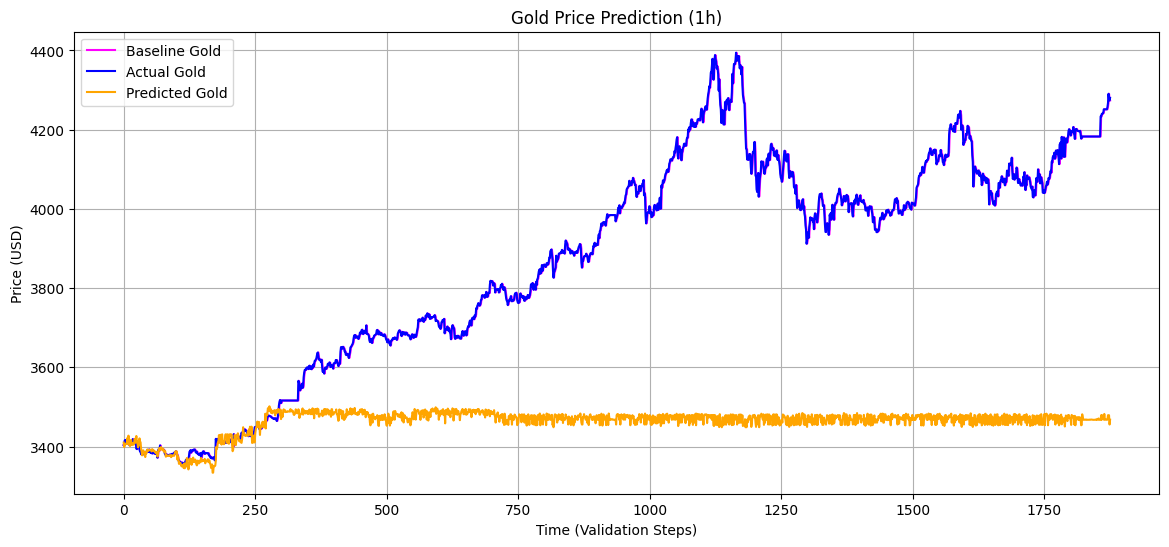

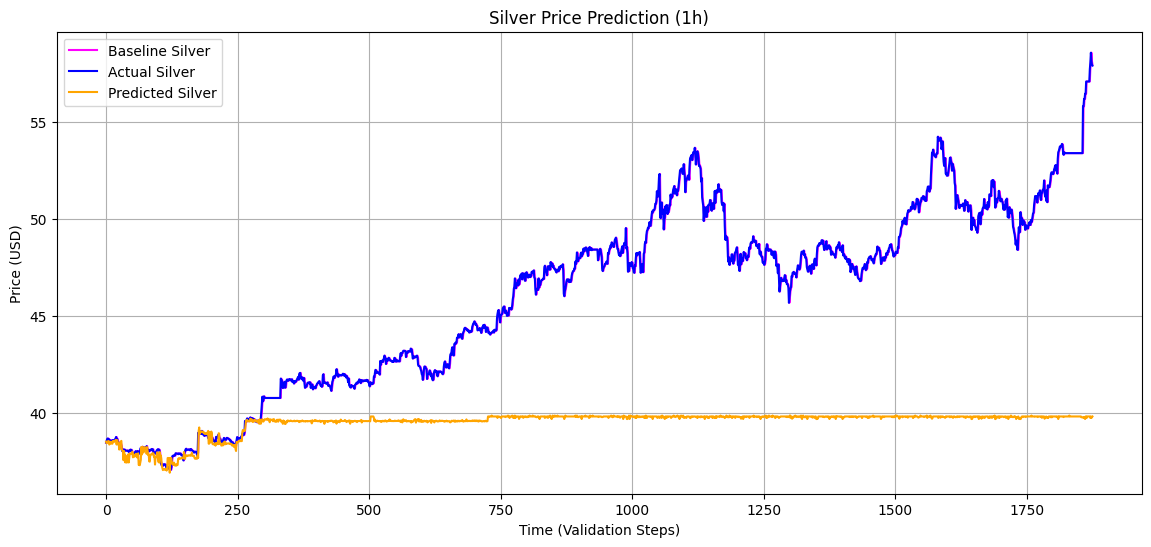

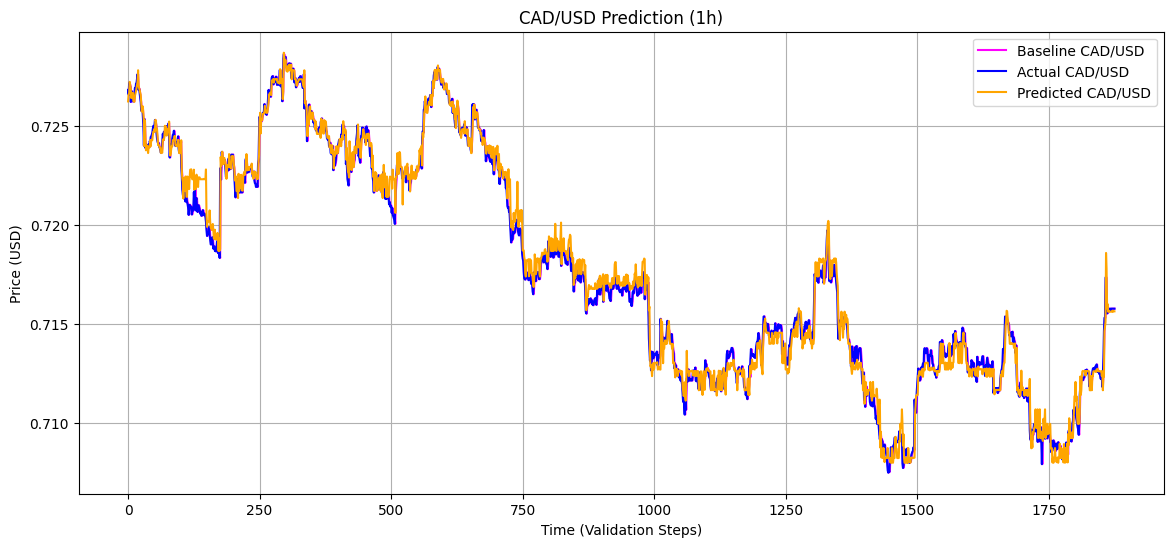

In [ ]:
# gold
plt.figure(figsize=(14,6))
plt.plot(baseline_gold, color="magenta", label="Baseline Gold")
plt.plot(actual_gold, color="blue", label="Actual Gold")
plt.plot(gold_pred, color="orange", label="Predicted Gold")
plt.title("Gold Price Prediction (1h)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# silver
plt.figure(figsize=(14,6))
plt.plot(baseline_silver, color="magenta", label="Baseline Silver")
plt.plot(actual_silver, color="blue", label="Actual Silver")
plt.plot(silver_pred, color="orange", label="Predicted Silver")
plt.title("Silver Price Prediction (1h)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# CAD
plt.figure(figsize=(14,6))
plt.plot(baseline_cad, color="magenta", label="Baseline CAD/USD")
plt.plot(actual_cad, color="blue", label="Actual CAD/USD")
plt.plot(cad_pred, color="orange", label="Predicted CAD/USD")
plt.title("CAD/USD Prediction (1h)")
plt.xlabel("Time (Validation Steps)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Mean Absolute Error :', mae)
print('Root Mean Squared Error :', rmse)
print('Mean Absolute Percentage Error :', mape)

Mean Absolute Error : 133.89306640625
Root Mean Squared Error : 271.6373961736491
Mean Absolute Percentage Error : 0.07779029756784439


In [ ]:
print("MAE:")
print("Gold  :", mean_absolute_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_error(y_test['CAD_target'], y_pred[:,2]))

print("RMSE:")
print("Gold  :", np.sqrt(mean_squared_error(y_test['Gold_target'], y_pred[:,0])))
print("Silver:", np.sqrt(mean_squared_error(y_test['Silver_target'], y_pred[:,1])))
print("CAD   :", np.sqrt(mean_squared_error(y_test['CAD_target'], y_pred[:,2])))

print("MAPE:")
print("Gold  :", mean_absolute_percentage_error(y_test['Gold_target'], y_pred[:,0]))
print("Silver:", mean_absolute_percentage_error(y_test['Silver_target'], y_pred[:,1]))
print("CAD   :", mean_absolute_percentage_error(y_test['CAD_target'], y_pred[:,2]))

MAE:
Gold  : 395.0700576879831
Silver: 6.608535266380066
CAD   : 0.0005079958675258449
RMSE:
Gold  : 470.4223415339218
Silver: 7.976587609882225
CAD   : 0.0006808572416926812
MAPE:
Gold  : 0.09783225685776073
Silver: 0.13482972449436254
CAD   : 0.0007088478934123122


In [ ]:
best_model.save_model('xgboost_1h.json')
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.6520985020245867, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=21, n_jobs=None,
             num_parallel_tree=None, ...)

# Future Predictions

In [ ]:
params = XGBRegressor()
params.load_model('xgboost_1h.json')
params = params.get_xgb_params()
model = XGBRegressor(**params)

# Fit this new model on the entire dataset (X, y)
model.fit(X, y)
model

XGBRegressor(base_score=[2655.3745, 30.28035, 0.7249217], booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def forecast_interval(model, df, start_date, end_date):

    lag = 3
    window = 5

    historical_raw_data = df[['Gold', 'Silver', 'CAD']].iloc[-window:].copy()

    predictions = []
    future_index = pd.date_range(start=start_date, end=end_date, freq="1h")

    training_columns = X.columns.tolist()

    for _ in future_index:

        current_features_dict = {}

        current_gold = historical_raw_data['Gold'].iloc[-1]
        current_silver = historical_raw_data['Silver'].iloc[-1]
        current_cad = historical_raw_data['CAD'].iloc[-1]

        current_features_dict['Gold'] = current_gold
        current_features_dict['Silver'] = current_silver
        current_features_dict['CAD'] = current_cad

        # Returns (needs current and previous)
        prev_gold = historical_raw_data['Gold'].iloc[-2]
        prev_silver = historical_raw_data['Silver'].iloc[-2]
        prev_cad = historical_raw_data['CAD'].iloc[-2]

        current_features_dict['Gold_ret'] = (current_gold - prev_gold) / prev_gold if prev_gold != 0 else 0
        current_features_dict['Silver_ret'] = (current_silver - prev_silver) / prev_silver if prev_silver != 0 else 0
        current_features_dict['CAD_ret'] = (current_cad - prev_cad) / prev_cad if prev_cad != 0 else 0

        # Moving Averages (needs last 5 values)
        current_features_dict['Gold_ma'] = historical_raw_data['Gold'].rolling(window).mean().iloc[-1]
        current_features_dict['Silver_ma'] = historical_raw_data['Silver'].rolling(window).mean().iloc[-1]
        current_features_dict['CAD_ma'] = historical_raw_data['CAD'].rolling(window).mean().iloc[-1]

        for lag in range(1, lag + 1):
            current_features_dict[f"Gold_lag_{lag}"] = historical_raw_data['Gold'].iloc[-lag-1]
            current_features_dict[f"Silver_lag_{lag}"] = historical_raw_data['Silver'].iloc[-lag-1]
            current_features_dict[f"CAD_lag_{lag}"] = historical_raw_data['CAD'].iloc[-lag-1]

        X_input_df = pd.DataFrame([current_features_dict], columns=training_columns)
        X_input = X_input_df.values.reshape(1, -1)

        y_pred = model.predict(X_input)[0]

        predictions.append(y_pred)

        historical_raw_data = historical_raw_data.iloc[1:].copy()

        new_pred_row = pd.DataFrame([y_pred], columns=['Gold', 'Silver', 'CAD'])
        historical_raw_data = pd.concat([historical_raw_data, new_pred_row], ignore_index=True)

    pred_df = pd.DataFrame(predictions, index=future_index, columns=df[['Gold', 'Silver', 'CAD']].columns)
    return pred_df

In [ ]:
future_start = "2025-12-1"
future_end   = "2025-12-2"

forecast_df = forecast_interval(model, all_prices, future_start, future_end)
forecast_df

,Gold,Silver,CAD
2025-12-01 00:00:00,4278.996094,57.861691,0.715685
2025-12-01 01:00:00,4335.527832,58.133640,0.715685
2025-12-01 02:00:00,4330.194336,58.139809,0.715923
2025-12-01 03:00:00,4315.690430,57.816700,0.716159
2025-12-01 04:00:00,4329.725586,57.549648,0.716103
2025-12-01 05:00:00,4340.643066,58.166451,0.716131
2025-12-01 06:00:00,4354.302246,57.094494,0.716163
2025-12-01 07:00:00,4298.974121,57.121799,0.716131
2025-12-01 08:00:00,4340.580078,56.882740,0.716137
2025-12-01 09:00:00,4341.871094,57.107937,0.716413
